Import libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import numpy as np

from glob import glob
import random
import os

Import data

In [6]:
df = pd.read_csv('../Downloads/ECS192/Datasets/Replication_scored.csv')

In [94]:
df

,Replication,Score_replication
0,it will no influence DNA replication,1
1,The G to A base change will not affect replica...,1
2,During DNA replication the entire DNA will be ...,1
3,In DNA replication the DNA would simply replic...,1
4,It wont have any direct effect besides that th...,1
...,...,...
1026,It will stop the function of the DNA.,3
1027,It will stop replication early.,3
1028,It will stop earlier then it should.,3
1029,The DNA will stop replication at the stop codo...,3


In [95]:
X = df['Replication']
y = df['Score_replication']

In [96]:
# from sklearn.preprocessing import LabelBinarizer
# y = LabelBinarizer().fit_transform(df.Score_replication)

In [28]:
# mylist = [0,0,0]
# df['one hot'] = np.tile(mylist, (len(df),1)).tolist()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [26]:
# for i in range(len(df)):
#     df['one hot'].iloc[i] = y[i]

In [97]:
# find the total number of words
df['new_column'] = df.Replication.apply(lambda x: len(str(x).split(' ')))
num_words = df.new_column.sum()

In [98]:
text = X.tolist()
labels = y.tolist()

In [99]:
def load_data(num_words, sequence_length, test_size=0.2, oov_token=None):
    # tokenize the dataset corpus, delete uncommon words such as names, etc.
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X, y = np.array(X), np.array(labels)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # convert labels to one-hot encoded
    y = to_categorical(y)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    data["int2label"] =  {0: "1", 1: "2", 2: "3"}
    data["label2int"] = {"1": 0, "2": 1, "3": 2}
    return data

In [100]:
def get_embedding_vectors(word_index, embedding_size=100):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"../Downloads/glove.42B.300d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [101]:
def create_model(word_index, units=128, n_layers=1, cell=LSTM, bidirectional=False,
                embedding_size=100, sequence_length=100, dropout=0.3, 
                loss="categorical_crossentropy", optimizer="adam", 
                output_length=2):
    """Constructs a RNN model given its parameters"""
    embedding_matrix = get_embedding_vectors(word_index, embedding_size)
    model = Sequential()
    # add the embedding layer
    model.add(Embedding(len(word_index) + 1,
              embedding_size,
              weights=[embedding_matrix],
              trainable=False,
              input_length=sequence_length))
    for i in range(n_layers):
        if i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # first layer or hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        model.add(Dropout(dropout))
    model.add(Dense(output_length, activation="softmax"))
    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    return model

In [102]:
# max number of words in each sentence
SEQUENCE_LENGTH = 300
# N-Dimensional GloVe embedding vectors
EMBEDDING_SIZE = 300
# number of words to use, discarding the rest
N_WORDS = 10000
# out of vocabulary token
OOV_TOKEN = None
# 30% testing set, 70% training set
TEST_SIZE = 0.2
# number of CELL layers
N_LAYERS = 1
# the RNN cell to use, LSTM in this case
RNN_CELL = LSTM
# whether it's a bidirectional RNN
IS_BIDIRECTIONAL = False
# number of units (RNN_CELL ,nodes) in each layer
UNITS = 128
# dropout rate
DROPOUT = 0.4
### Training parameters
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 10

def get_model_name(dataset_name):
    # construct the unique model name
    model_name = f"{dataset_name}-{RNN_CELL.__name__}-seq-{SEQUENCE_LENGTH}-em-{EMBEDDING_SIZE}-w-{N_WORDS}-layers-{N_LAYERS}-units-{UNITS}-opt-{OPTIMIZER}-BS-{BATCH_SIZE}-d-{DROPOUT}"
    if IS_BIDIRECTIONAL:
        # add 'bid' str if bidirectional
        model_name = "bid-" + model_name
    if OOV_TOKEN:
        # add 'oov' str if OOV token is specified
        model_name += "-oov"
    return model_name

In [103]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")
# dataset name, IMDB movie reviews dataset
dataset_name = "imdb"
# get the unique model name based on hyper parameters on parameters.py
model_name = get_model_name(dataset_name)
# load the data
data = load_data(N_WORDS, SEQUENCE_LENGTH, TEST_SIZE, oov_token=OOV_TOKEN)
# construct the model
model = create_model(data["tokenizer"].word_index, units=UNITS, n_layers=N_LAYERS, 
                    cell=RNN_CELL, bidirectional=IS_BIDIRECTIONAL, embedding_size=EMBEDDING_SIZE, 
                    sequence_length=SEQUENCE_LENGTH, dropout=DROPOUT, 
                    loss=LOSS, optimizer=OPTIMIZER, output_length=data["y_train"][0].shape[0])
model.summary()
# using tensorboard on 'logs' folder
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# start training
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[tensorboard],
                    verbose=1)
# save the resulting model into 'results' folder
model.save(os.path.join("results", model_name) + ".h5")

<ipython-input-99-7db7c6a0cf1e>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X, y = np.array(X), np.array(labels)
Reading GloVe: 1917495it [00:50, 38281.92it/s]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          346800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 566,964
Trainable params: 220,164
Non-trainable params: 346,800
_________________________________________________________________
Epoch 1/10
13/13 [==============================] - 8s 498ms/step - loss: 1.0742 - accuracy: 0.4927 - val_loss: 0.9242 - val_accuracy: 0.5942
Epoch 2/10
13/13 [==============================] - 6s 497ms/step - loss: 0.8067 - accuracy: 0.635

In [121]:
def get_predictions(text):
    sequence = data["tokenizer"].texts_to_sequences([text])
    # pad the sequences
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = model.predict(sequence)[0]
    return prediction, data["int2label"][np.argmax(prediction)]

In [129]:
text = new_text
output_vector, prediction = get_predictions(text)
print("Output vector:", output_vector)
print("Prediction:", prediction)

Output vector: [0.08682992 0.6174334  0.24125782 0.05447892]
Prediction: 2


In [128]:
new_text = str(data['X_test'][100])

**Another Method**

In [79]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitasingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
%cd /Users/ankitasingh/Downloads

In [8]:
df = pd.read_csv('../Downloads/ECS192/Datasets/Replication_scored.csv')

In [39]:
df

,Replication,Score_replication
0,it will no influence DNA replication,1
1,The G to A base change will not affect replica...,1
2,During DNA replication the entire DNA will be ...,1
3,In DNA replication the DNA would simply replic...,1
4,It wont have any direct effect besides that th...,1
...,...,...
1026,It will stop the function of the DNA.,3
1027,It will stop replication early.,3
1028,It will stop earlier then it should.,3
1029,The DNA will stop replication at the stop codo...,3


In [60]:
X = df['Replication'].tolist()
y = df['Score_replication'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [80]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Replication'] = df['Replication'].apply(clean_text)

In [81]:
df['Replication'] = df['Replication'].str.replace('\d+', '')

In [82]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Replication'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1038 unique tokens.


In [83]:
X = tokenizer.texts_to_sequences(df['Replication'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1031, 250)


In [85]:
Y = pd.get_dummies(df['Score_replication']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1031, 3)


In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(824, 250) (824, 3)
(207, 250) (207, 3)


In [95]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
11/11 [==============================] - 5s 392ms/step - loss: 0.4665 - accuracy: 0.8240 - val_loss: 0.6249 - val_accuracy: 0.7515
Epoch 2/10
11/11 [==============================] - 4s 384ms/step - loss: 0.3899 - accuracy: 0.8604 - val_loss: 0.6416 - val_accuracy: 0.7758
Epoch 3/10
11/11 [==============================] - 4s 379ms/step - loss: 0.3079 - accuracy: 0.9044 - val_loss: 0.5773 - val_accuracy: 0.8000
Epoch 4/10
11/11 [==============================] - 5s 424ms/step - loss: 0.2857 - accuracy: 0.9120 - val_loss: 0.6155 - val_accuracy: 0.8000
Epoch 5/10
11/11 [==============================] - 4s 368ms/step - loss: 0.2074 - accuracy: 0.9317 - val_loss: 0.6219 - val_accuracy: 0.8061
Epoch 6/10
11/11 [==============================] - 4s 362ms/step - loss: 0.2679 - accuracy: 0.9226 - val_loss: 0.5942 - val_accuracy: 0.8061


In [98]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 0s 40ms/step - loss: 0.7331 - accuracy: 0.7778
Test set
  Loss: 0.733
  Accuracy: 0.778


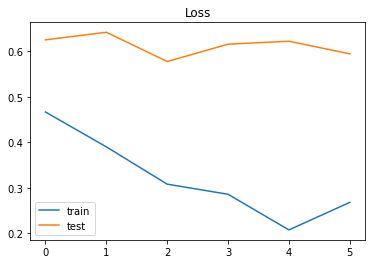

In [99]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [103]:
new_complaint = ['DNA replication will not be affected.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1', '2', '3']
print(pred, labels[np.argmax(pred)])

[[0.893483   0.02102285 0.08549421]] 1


**Text Classification with Bert**

In [2]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import pandas as pd

In [3]:
df = pd.read_csv('Replication_scored_copy.csv')

In [4]:
possible_labels = df.Score_replication.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{1: 0, 2: 1, 3: 2}

In [5]:
df['label'] = df.Score_replication.replace(label_dict)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['Score_replication', 'label', 'data_type']).count()

Replication
Score_replication label data_type             
1                 0     train              426
                        val                 76
2                 1     train              166
                        val                 29
3                 2     train              284
                        val                 50

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [8]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Replication.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt',
    truncation= True
)

/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Replication.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt',
    truncation = True
)

In [10]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [11]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [13]:
batch_size = 5

In [14]:
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [16]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [17]:
epochs = 5

In [18]:
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [19]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [20]:
import numpy as np
device = 'cpu'

In [21]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    

In [22]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

KeyboardInterrupt: 

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

In [23]:
model.load_state_dict(torch.load('finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: 1
Accuracy: 63/76

Class: 2
Accuracy: 12/29

Class: 3
Accuracy: 44/50



**Another Bert approach**

In [138]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [139]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [140]:
df = pd.read_csv('Replication_scored_copy.csv')

In [141]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [142]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.Replication[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.Score_replication[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [143]:
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1031, 2)
TRAIN Dataset: (825, 2)
TEST Dataset: (206, 2)


In [144]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [145]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [146]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [147]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [148]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [149]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [150]:
for epoch in range(EPOCHS):
    train(epoch)

Training Loss per 5000 steps: 1.5235838890075684
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 0: 54.303030303030305
Training Loss Epoch: 1.0258348341581327
Training Accuracy Epoch: 54.303030303030305
Training Loss per 5000 steps: 0.31326359510421753
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 74.54545454545455
Training Loss Epoch: 0.7192864210709281
Training Accuracy Epoch: 74.54545454545455
Training Loss per 5000 steps: 1.12823486328125
Training Accuracy per 5000 steps: 25.0
The Total Accuracy for Epoch 2: 80.96969696969697
Training Loss Epoch: 0.530789656051691
Training Accuracy Epoch: 80.96969696969697


In [151]:
def valid(model, testing_loader):
    model.eval()
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [152]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.9930866360664368
Validation Accuracy per 100 steps: 50.0
Validation Loss Epoch: 0.639574985481003
Validation Accuracy Epoch: 72.81553398058253
Accuracy on test data = 72.82%


In [157]:
# Saving the files for re-use

output_model_file = '/models/pytorch_distilbert_news.bin'
output_vocab_file = '/models/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save.state_dict, 'bert_model.pt')
tokenizer.save_vocabulary('vocab_distilbert_news.bin')

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


**Roberta Method**

In [74]:
import pandas as pd

In [75]:
from sklearn.model_selection import train_test_split

In [88]:
df = pd.read_csv('data/Replication_scored.csv')

In [89]:
df.rename(columns={'Replication': 'text', 'Score_replication': 'labels'}, inplace = True)

In [90]:
df['text'] = df['text'].astype(str)
df['labels'] = df['labels'].astype(int)

In [91]:
train, test = train_test_split(df, test_size=0.2)

In [92]:
from simpletransformers.classification import ClassificationModel


# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', num_labels=4, use_cuda=False, 
                            args={'learning_rate':1e-5, 'num_train_epochs': 3,
                                  'reprocess_input_data': True, 'overwrite_output_dir': True})

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [93]:
model.train_model(train)

/opt/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(309, 0.8735930786067229)

In [95]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test, f1=f1_multiclass, acc=accuracy_score)


In [96]:
result

{'mcc': 0.763392415762375,
 'f1': 0.855072463768116,
 'acc': 0.855072463768116,
 'eval_loss': 0.4600811147919068}

# Model with XLNet

In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('data/Replication_scored.csv')
df.rename(columns={'Replication': 'text', 'Score_replication': 'labels'}, inplace = True)
df['text'] = df['text'].astype(str)
df['labels'] = df['labels'].astype(int)
train, test = train_test_split(df, test_size=0.2)

In [4]:
from simpletransformers.classification import ClassificationModel


# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=3, use_cuda=False, 
                            args={'learning_rate':1e-5, 'num_train_epochs': 2,
                                  'reprocess_input_data': True, 'overwrite_output_dir': True})

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [5]:
model.train_model(train)

IndexError: Target 3 is out of bounds.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test, f1=f1_multiclass, acc=accuracy_score, conf=confusion_matrix)


In [ ]:
result['conf']